In [1226]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd

In [874]:
def initialize_centroids_kmeans_plusplus(X, n_clusters):
    first_centroid_idex = np.random.randint(0, len(X))
    centroids = [X[first_centroid_idex]]
    for i in range(1, n_clusters):
        distances = np.array([min(np.linalg.norm(x - c)**2 for c in centroids) for x in X])
        next_centroid_idex = np.random.choice(len(X), p=distances / distances.sum())
        centroids.append(X[next_centroid_idex])   
    return np.array(centroids)

def assign_clusters(X, centroids):
    distances = []
    for i in range(X.shape[0]):
        distances.append([np.linalg.norm(X[i, ] - centroids[j]) for j in range(len(centroids))])
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, n_clusters):
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
    return new_centroids

def k_means(X, n_clusters, max_iters=100):
    centroids = initialize_centroids_kmeans_plusplus(X, n_clusters)   
    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, n_clusters) 
        if np.all(new_centroids == centroids):
            break
        centroids = new_centroids
    return labels, centroids

def kmeans_objective(X, centroids, labels):
    loss = 0.0
    for i in range(X.shape[0]):
        cluster_idex = labels[i]
        centroid = centroids[cluster_idex]
        distance = np.linalg.norm(X[i] - centroid) ** 2
        loss += distance
    return loss

def kmeans_accuracy(labels, y, map):
    accuracy = 0
    for i in range(len(y)):
        if y[i] == map[labels[i]]:
            accuracy += 1
    return accuracy/len(y)

In [902]:
def em_init(X,num_clusters): 
    p_zi = np.ones(num_clusters) / num_clusters
    # initialize with one row 
    random_indices = np.random.choice(len(X),size=num_clusters) 
    mu = X[random_indices, :] 
    ## initilize with identity matrix
    sigma = []
    random_identity = np.zeros((X.shape[1], X.shape[1]))
    np.fill_diagonal(random_identity, 1)
    for i in range(num_clusters):
        sigma.append(random_identity)
    sigma = np.array(sigma)
    return mu,sigma,p_zi

def e_step(X,num_clusters,mu,sigma,p_zi):
    weights = np.zeros((num_clusters,len(X)))
    for j in range(num_clusters):
        weights[j] = multivariate_normal(mean=mu[j], cov=sigma[j]).pdf(X) * p_zi[j]
    return weights/np.sum(weights,axis=0)

def m_step(X,weights,mu,sigma,num_clusters,p_zi):
    for j in range(num_clusters):  
        p_zi[j] = np.mean(weights[j])
        mu[j] = np.sum(weights[j][:,np.newaxis] * X,axis=0) / (np.sum(weights[j]))
        temp = X - mu[j]
        sigma[j] = np.sum(weights[j][:, np.newaxis, np.newaxis]  * (temp[:, :, np.newaxis] * temp[:, np.newaxis, :]) ,axis=0) / (np.sum(weights[j]))
    return mu,sigma,p_zi

def train_gmm(data,num_clusters,max_iters=100):    
    mu,sigma, p_zi = em_init(data, num_clusters)
    for step in range(max_iters):
        weights = e_step(data,num_clusters,mu,sigma, p_zi)
        mu,sigma, p_zi = m_step(data, weights, mu, sigma, num_clusters, p_zi)
    return mu, sigma, p_zi

def gmm_objective(mu, sigma,p_zi, data,num_clusters):
    log_likelihood = 0.0
    for i in range(len(data)):
        likelihoods = [p_zi[k] * multivariate_normal.pdf(data[i], mean=mu[k], cov=sigma[k]) for k in range(num_clusters)]
        log_likelihood += np.log(np.sum(likelihoods))
    return -log_likelihood

def gmm_accuracy(mu, sigma,p_zi, data,num_clusters, y, map):
    accuracy = 0
    for i in range(len(y)):
        labels = [p_zi[j] * multivariate_normal.pdf(data[i], mean=mu[j], cov=sigma[j]) for j in range(num_clusters)]
        label = np.argmax(labels)
        if y[i] == map[label]:
            accuracy += 1
    return accuracy/len(y)

In [907]:
sigmas = [0.5,1,2,4,8]
num_samples = 100  
num_clusters = 3
kmeans_obj = []
kmeans_acc = []
gmm_obj = []
gmm_acc = []
for sigma in sigmas:
    cluster_means = np.array([[-1, -1], [1, -1], [1, 0]]) 
    cluster_covs = sigma * np.array([[[2, 0.5], [0.5, 1]],[[1, -0.5], [-0.5, 2]],[[1, 0], [0, 2]]])
    data = []
    y = []
    for j in range(num_clusters):
        for i in range(num_samples):
            sample = np.random.multivariate_normal(cluster_means[j], cluster_covs[j])
            data.append(sample)
            y.append(j)
    data = np.array(data)
    labels, centroids = k_means(data, 3)
    kmeans_obj.append(kmeans_objective(data, centroids, labels))
    assignment = [np.argmin([np.linalg.norm(centroids[i] - cluster_means[j]) for j in range(len(cluster_means))])for i in range(len(centroids)) ]
    kmeans_acc.append(kmeans_accuracy(labels, y, assignment))
    mu, sigma, p_zi = train_gmm(data,3,500)
    gmm_obj.append(gmm_objective(mu, sigma, p_zi, data, num_clusters))
    assignment = [np.argmin([np.linalg.norm(mu[i] - cluster_means[j]) for j in range(len(cluster_means))])for i in range(len(mu))]
    gmm_acc.append(gmm_accuracy(mu, sigma, p_zi, data, num_clusters, y, assignment))

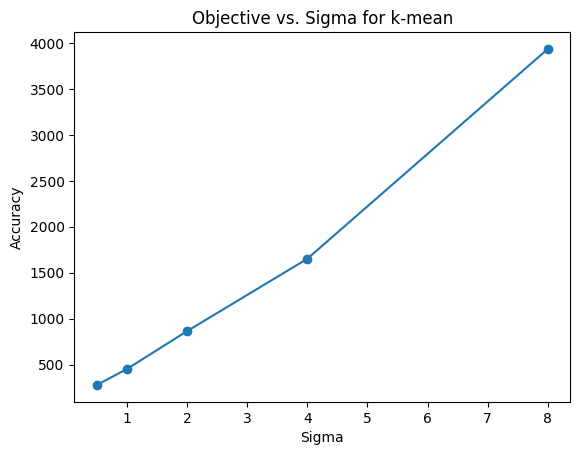

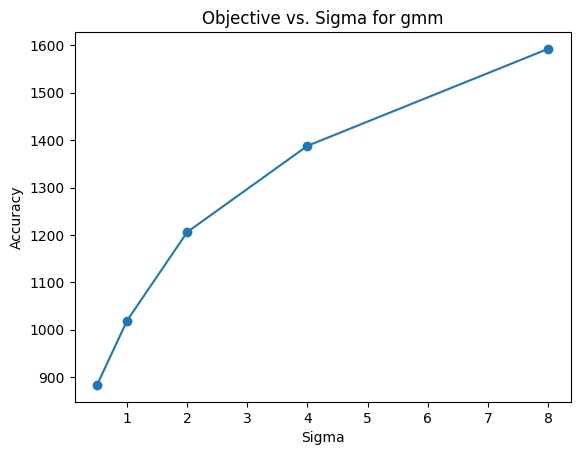

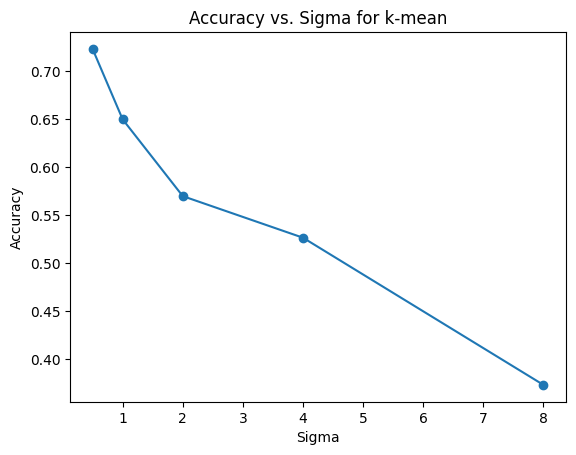

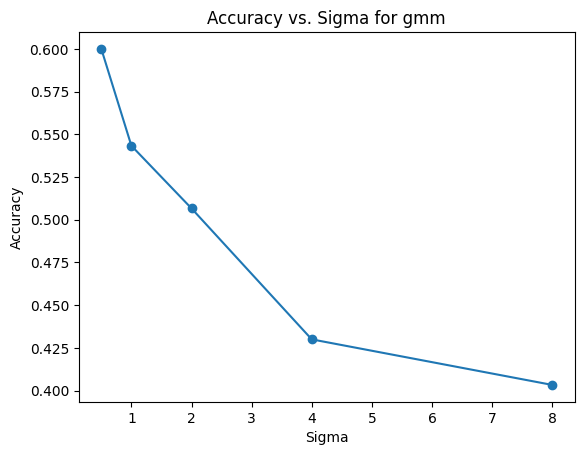

In [908]:
plt.plot(sigmas, kmeans_obj, marker='o', linestyle='-')
plt.title('Objective vs. Sigma for k-mean')
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.show()

plt.plot(sigmas, gmm_obj, marker='o', linestyle='-')
plt.title('Objective vs. Sigma for gmm')
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.show()

plt.plot(sigmas, kmeans_acc, marker='o', linestyle='-')
plt.title('Accuracy vs. Sigma for k-mean')
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.show()

plt.plot(sigmas, gmm_acc, marker='o', linestyle='-')
plt.title('Accuracy vs. Sigma for gmm')
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.show()

In [1227]:
data_2d = pd.read_csv('data2D.csv', header=None)
data_1000d = pd.read_csv('data1000D.csv', header=None)

In [1334]:
def buggy_pca(data, num_components):
    U, S, Vt = np.linalg.svd(data, full_matrices=False)
    eigenvectors = Vt[:num_components]
    projected_data = np.dot(data, eigenvectors.T)
    return eigenvectors,projected_data

def reconstruct_buggy_pca(projected_data, eigenvectors):
    reconstructed_data = np.dot(projected_data, eigenvectors)
    #print(reconstructed_data)
    return reconstructed_data

def demeaned_pca(data, num_components):
    mean = np.mean(data, axis=0)
    demeaned_data = data - mean
    eigenvectors,projected_data = buggy_pca(demeaned_data, num_components)
    return eigenvectors,projected_data, mean

def reconstruct_demeaned_pca(projected_data, eigenvectors, mean):
    reconstructed_data = np.dot(projected_data, eigenvectors) + np.array(mean)
    return reconstructed_data

def normalized_pca(data, num_components):
    mean = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    normalized_data = (data - mean)/sd
    eigenvectors,projected_data = buggy_pca(normalized_data, num_components)
    return eigenvectors, projected_data, mean, sd

def reconstruct_normalized_pca(projected_data, eigenvectors, mean, sd):
    reconstructed_data = np.dot(projected_data, eigenvectors) * np.array(sd)  + np.array(mean)
    return reconstructed_data


def calculate_error(original_data, reconstructed_data):
    reconstruction_error = np.mean(np.linalg.norm(original_data - reconstructed_data,axis=1)**2)
    return reconstruction_error

def dro(data, num_components):
    data = np.array(data)
    one_vector = np.ones(len(data)).reshape(-1,1)
    b = data.T @ one_vector /len(data)
    y = data - one_vector @ one_vector.T @ data/len(data)
    U, S, Vt = np.linalg.svd(y, full_matrices=False)
    Z = U[:,:num_components] * np.sqrt(len(data))
    S = np.diag(S)
    A = (S[:num_components,:]@Vt).T/ np.sqrt(len(data))
    reconstructed_data = Z@A.T + one_vector @ b.T
    return b, Z, A, reconstructed_data


In [1335]:
data = np.array(data_1000d)
one_vector = np.ones(len(data)).reshape(-1,1)
b = data.T @ one_vector/len(data)
y = data - one_vector @ one_vector.T @ data/len(data)
U, S, Vt = np.linalg.svd(y, full_matrices=False)
# Z = U[:,:1] * np.sqrt(len(data))
# S = np.diag(S)
# A = (S[:100,:]@Vt).T/ np.sqrt(len(data))

Vt.shape
S.shape


(500,)

Reconstruction error for Buggy PCA 0.8869030837347942


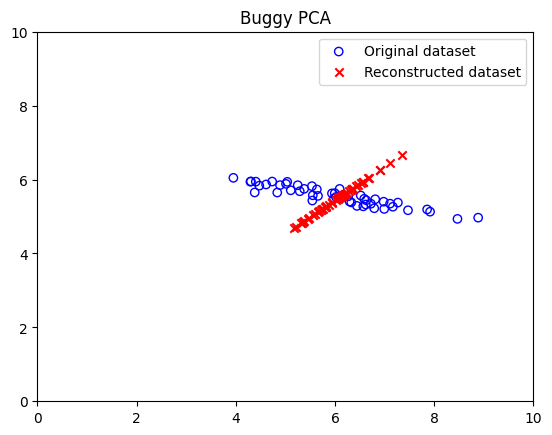

Reconstruction error for Demeaned PCA 0.010006085628512917


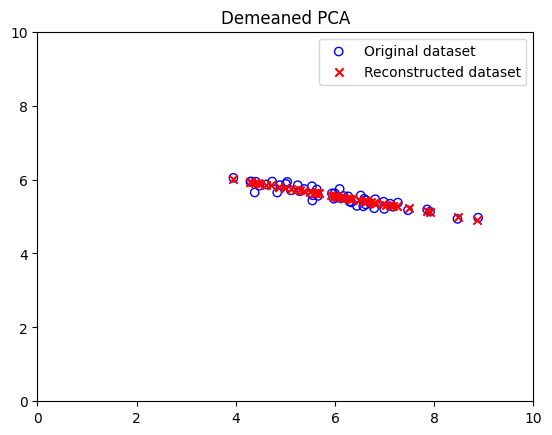

Reconstruction error for Normalized PCA 0.04947208345477067


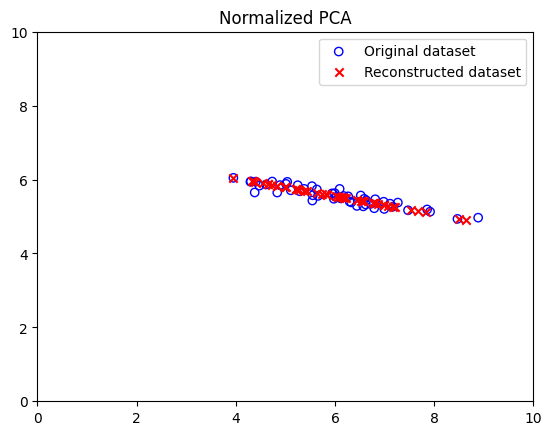

Reconstruction error for DRO 0.01000608562851292


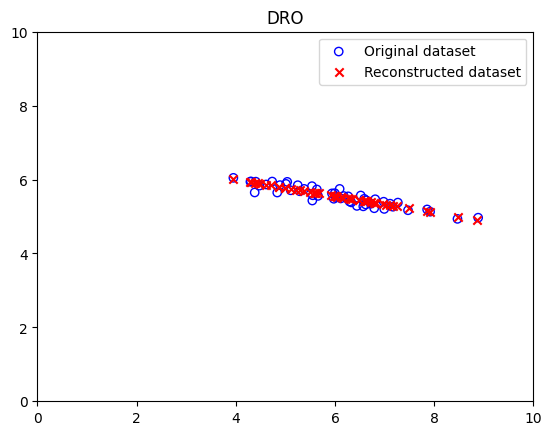

In [1359]:
eigenvectors, projected_data = buggy_pca(data_2d, 1)
reconstructed_data = reconstruct_buggy_pca(projected_data, eigenvectors)
calculate_error(data_2d,reconstructed_data)
reconstructed_data = pd.DataFrame(reconstructed_data)
print("Reconstruction error for Buggy PCA", calculate_error(data_2d,reconstructed_data))
plt.scatter(data_2d[0], data_2d[1], marker='o', facecolors='none',edgecolors='blue',label = "Original dataset")
plt.scatter(reconstructed_data[0], reconstructed_data[1], marker='x', color='red',label = "Reconstructed dataset")
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("Buggy PCA")
plt.legend()
plt.show()

eigenvectors, projected_data,mean = demeaned_pca(data_2d, 1)
reconstructed_data = reconstruct_demeaned_pca(projected_data, eigenvectors,mean)
reconstructed_data = pd.DataFrame(reconstructed_data)
print("Reconstruction error for Demeaned PCA", calculate_error(data_2d,reconstructed_data))
plt.scatter(data_2d[0], data_2d[1], marker='o', facecolors='none',edgecolors='blue',label = "Original dataset")
plt.scatter(reconstructed_data[0], reconstructed_data[1], marker='x', color='red',label = "Reconstructed dataset")
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("Demeaned PCA")
plt.legend()
plt.show()

eigenvectors, projected_data, mean, sd = normalized_pca(data_2d, 1)
reconstructed_data = reconstruct_normalized_pca(projected_data, eigenvectors,mean,sd)
reconstructed_data = pd.DataFrame(reconstructed_data)
print("Reconstruction error for Normalized PCA", calculate_error(data_2d,reconstructed_data))
plt.scatter(data_2d[0], data_2d[1], marker='o', facecolors='none',edgecolors='blue',label = "Original dataset")
plt.scatter(reconstructed_data[0], reconstructed_data[1], marker='x', color='red',label = "Reconstructed dataset")
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("Normalized PCA")
plt.legend()
plt.show()

b, Z, A, reconstructed_data = dro(data_2d,1)
reconstructed_data = pd.DataFrame(reconstructed_data)
print("Reconstruction error for DRO", calculate_error(data_2d,reconstructed_data))
plt.scatter(data_2d[0], data_2d[1], marker='o', facecolors='none',edgecolors='blue',label = "Original dataset")
plt.scatter(reconstructed_data[0], reconstructed_data[1], marker='x', color='red',label = "Reconstructed dataset")
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("DRO")
plt.legend()
plt.show()

In [1352]:
error = []
for i in range(1, 50, 1):
    b, Z, A, reconstructed_data = dro(data_1000d,i)
    reconstructed_data = pd.DataFrame(reconstructed_data)
    print("Reconstruction error for DRO with d =",i, "is", calculate_error(data_1000d,reconstructed_data))
    error.append(calculate_error(data_1000d,reconstructed_data))

Reconstruction error for DRO with d = 1 is 28021.361212827087
Reconstruction error for DRO with d = 2 is 26403.710500563964
Reconstruction error for DRO with d = 3 is 24937.97729494043
Reconstruction error for DRO with d = 4 is 23589.485096525805
Reconstruction error for DRO with d = 5 is 22241.593862150556
Reconstruction error for DRO with d = 6 is 20930.2843777358
Reconstruction error for DRO with d = 7 is 19718.82299053778
Reconstruction error for DRO with d = 8 is 18579.53412695959
Reconstruction error for DRO with d = 9 is 17448.44995856032
Reconstruction error for DRO with d = 10 is 16350.450533541798
Reconstruction error for DRO with d = 11 is 15263.19283060523
Reconstruction error for DRO with d = 12 is 14211.0225381065
Reconstruction error for DRO with d = 13 is 13220.594758133926
Reconstruction error for DRO with d = 14 is 12270.537660522497
Reconstruction error for DRO with d = 15 is 11330.148369214732
Reconstruction error for DRO with d = 16 is 10402.426183086063
Reconstruc

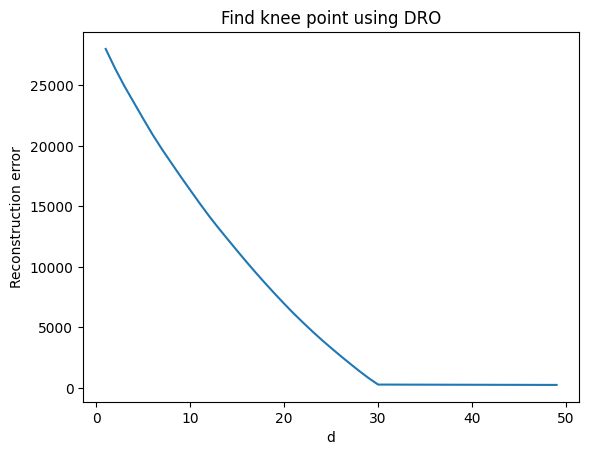

In [1354]:
plt.plot(np.array(range(1,50)),error,'-')
plt.title("Find knee point using DRO")
plt.ylabel("Reconstruction error")
plt.xlabel("d")
plt.show()

In [1340]:
np.array(range(1,100))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [1363]:
# So, we choose d = 30
eigenvectors, projected_data = buggy_pca(data_1000d, 30)
reconstructed_data = reconstruct_buggy_pca(projected_data, eigenvectors)
calculate_error(data_1000d,reconstructed_data)
reconstructed_data = pd.DataFrame(reconstructed_data)
print("Reconstruction error for Buggy PCA", calculate_error(data_1000d,reconstructed_data))

eigenvectors, projected_data,mean = demeaned_pca(data_1000d, 30)
reconstructed_data = reconstruct_demeaned_pca(projected_data, eigenvectors,mean)
reconstructed_data = pd.DataFrame(reconstructed_data)
print("Reconstruction error for Demeaned PCA", calculate_error(data_1000d,reconstructed_data))

eigenvectors, projected_data, mean, sd = normalized_pca(data_1000d, 30)
reconstructed_data = reconstruct_normalized_pca(projected_data, eigenvectors,mean,sd)
reconstructed_data = pd.DataFrame(reconstructed_data)
print("Reconstruction error for Normalized PCA", calculate_error(data_1000d,reconstructed_data))

b, Z, A, reconstructed_data = dro(data_1000d,30)
reconstructed_data = pd.DataFrame(reconstructed_data)
print("Reconstruction error for DRO", calculate_error(data_1000d,reconstructed_data))

Reconstruction error for Buggy PCA 802.7313986203584
Reconstruction error for Demeaned PCA 273.0459589786028
Reconstruction error for Normalized PCA 273.6285809976233
Reconstruction error for DRO 273.0459589786028
